In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm 
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
housing_int_df = pd.read_csv("../data/processed data/housing_mortgage_final.csv")
housing_int_df['Date'] = pd.to_datetime(housing_int_df['Date'])
print(housing_int_df.dtypes, housing_int_df.shape)
housing_int_df.head()

state_name                   object
county_name                  object
Date                 datetime64[ns]
Price                       float64
mortgage_int_rate           float64
dtype: object (13780, 5)


,state_name,county_name,Date,Price,mortgage_int_rate
0,California,Fresno,2000-01-31,121248.0,8.21
1,California,Kern,2000-01-31,108969.0,8.21
2,California,Los Angeles,2000-01-31,231141.0,8.21
3,California,Monterey,2000-01-31,268911.0,8.21
4,California,Napa,2000-01-31,247799.0,8.21


In [3]:
# Removing data uptil 2012, to eliminate the non linear post recession dip
date = pd.to_datetime('2012-12-31')
mask = housing_int_df['Date'] > date
housing_int_2012 = housing_int_df.loc[mask]
housing_int_2012.head()

,state_name,county_name,Date,Price,mortgage_int_rate
8112,California,Fresno,2013-01-31,165879.0,3.414
8113,California,Kern,2013-01-31,146547.0,3.414
8114,California,Los Angeles,2013-01-31,425542.0,3.414
8115,California,Monterey,2013-01-31,342353.0,3.414
8116,California,Napa,2013-01-31,419359.0,3.414


In [4]:
housing_int_2012.reset_index(drop=True, inplace=True)
housing_int_2012.tail()

,state_name,county_name,Date,Price,mortgage_int_rate
5663,Washington,Kitsap,2022-01-31,552864.0,3.445
5664,Washington,Skagit,2022-01-31,562064.0,3.445
5665,Washington,Spokane,2022-01-31,411352.0,3.445
5666,Washington,Thurston,2022-01-31,502325.0,3.445
5667,Washington,Walla Walla,2022-01-31,381225.0,3.445


<b>Separating values from "2021-07-31" to "2022-01-31", to save it latter for model prediction. Saving data prior to "2021-07-31" into training dataframe</b>

In [5]:
LA_hou_mor = housing_int_2012[(housing_int_2012["state_name"]=="California") & (housing_int_2012["county_name"]=="Los Angeles")]
LA_hou_mor.reset_index(drop=True, inplace= True)
dt_separate = pd.to_datetime('2021-06-30')
date_ord = list(range(1,LA_hou_mor.shape[0] + 1))
#LA_hou_mor["Date_ord"] = date_ord
LA_hou_mor['Date_ord']= LA_hou_mor['Date'].map(dt.datetime.toordinal)
LA_hou_mor_train = LA_hou_mor[LA_hou_mor['Date'] <= dt_separate]
LA_hou_mor_topred = LA_hou_mor[LA_hou_mor['Date'] > dt_separate]

In [6]:
De_hou_mor = housing_int_2012[(housing_int_2012["state_name"]=="Colorado") & (housing_int_2012["county_name"]=="Denver")]
De_hou_mor.reset_index(drop=True, inplace= True)
#De_hou_mor["Date_ord"] = date_ord
De_hou_mor['Date_ord']= De_hou_mor['Date'].map(dt.datetime.toordinal)
De_hou_mor_train = De_hou_mor[De_hou_mor['Date'] <= dt_separate]
De_hou_mor_topred = De_hou_mor[De_hou_mor['Date'] > dt_separate]

In [7]:
Da_hou_mor = housing_int_2012[(housing_int_2012["state_name"]=="Texas") & (housing_int_2012["county_name"]=="Dallas")]
Da_hou_mor.reset_index(drop=True, inplace= True)
#Da_hou_mor["Date_ord"] = date_ord
Da_hou_mor['Date_ord']= Da_hou_mor['Date'].map(dt.datetime.toordinal)
Da_hou_mor_train = Da_hou_mor[(Da_hou_mor['Date'] <= dt_separate)]
Da_hou_mor_topred = Da_hou_mor[(Da_hou_mor['Date'] > dt_separate)]

In [8]:
VB_hou_mor = housing_int_2012[(housing_int_2012["state_name"]=="Virginia") & (housing_int_2012["county_name"]=="Virginia Beach")]
VB_hou_mor.reset_index(drop=True, inplace= True)
#VB_hou_mor["Date_ord"] = date_ord
VB_hou_mor['Date_ord']= VB_hou_mor['Date'].map(dt.datetime.toordinal)
VB_hou_mor_train = VB_hou_mor[VB_hou_mor['Date'] <= dt_separate]
VB_hou_mor_topred = VB_hou_mor[VB_hou_mor['Date'] > dt_separate]

In [9]:
Ki_hou_mor = housing_int_2012[(housing_int_2012["state_name"]=="Washington") & (housing_int_2012["county_name"]=="King")]
Ki_hou_mor.reset_index(drop=True, inplace= True)
#Ki_hou_mor["Date_ord"] = date_ord
Ki_hou_mor['Date_ord']= Ki_hou_mor['Date'].map(dt.datetime.toordinal)
Ki_hou_mor_train = Ki_hou_mor[Ki_hou_mor['Date'] <= dt_separate]
Ki_hou_mor_topred = Ki_hou_mor[Ki_hou_mor['Date'] > dt_separate]

In [10]:
Ki_hou_mor.head()

,state_name,county_name,Date,Price,mortgage_int_rate,Date_ord
0,Washington,King,2013-01-31,282355.0,3.4140,734899
1,Washington,King,2013-02-28,285711.0,3.5325,734927
2,Washington,King,2013-03-31,289809.0,3.5650,734958
3,Washington,King,2013-04-30,294786.0,3.4450,734988
4,Washington,King,2013-05-31,299060.0,3.5360,735019


# Multiple linear regression model: with date and mortgage interest rate as features

In [11]:
#sklearn Linear Regression modelling function

def Linear_Regression(df,df_topred, multipleLR, scale):
    county_state = str(df["county_name"].iloc[0]) + ", " + str(df["state_name"].iloc[0])
    if multipleLR:
        X = df[["Date_ord","mortgage_int_rate"]]
        X_topred = df_topred[["Date_ord","mortgage_int_rate"]]
        mul_linear_reg = 1 
    else:
        #X = df.Date_ord.values.reshape(-1,1)
        #X_topred = df_topred.Date_ord.values.reshape(-1,1)
        X = df[["Date_ord"]]
        X_topred = df_topred[["Date_ord"]]
        mul_linear_reg = 0
    y= df.Price
    y_topred = df_topred.Price
    
    #X_train = X.loc[:82]
    #X_test = X.loc[83:]
    #y_train = y.loc[:82]
    #y_test = y.loc[83:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        X_topred = scaler.transform(X_topred)
        
        scale = 1
    else:
        scale = 0
        
    # Fitting data to model and predicting on test data
    LR_model = LinearRegression()
    LR_model.fit(X_train, y_train)
    
    print("Test Prediction")
    y_pred_test = LR_model.predict(X_test)
    test_pred = pd.DataFrame({'Actual_test': y_test, 'Predicted_test':  y_pred_test})
    print(test_pred.head(3))
    R2 = round(r2_score(y_test,y_pred_test),2)
    MAE = round(mean_absolute_error(y_test, y_pred_test),2)
    MSE = round(mean_squared_error(y_test, y_pred_test),2)
    RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),2)
    print("R2 score for test prediction: {}".format(R2)) 
    
    print("\nActual prediction")
    y_pred = LR_model.predict(X_topred)
    pred = pd.DataFrame({'Date': df_topred["Date"],'Actual': y_topred, 'Predicted':  y_pred})
    print(pred)
    R2_pred = round(r2_score(y_topred,y_pred),2)
    print("R2 score for actual prediction: {}".format(R2_pred))
        
    metrics_dict = {"county_state": county_state,"mul_linear_reg": mul_linear_reg,"scale": scale,"R2": R2, "R2_pred": R2_pred, "MAE": MAE,"MSE": MSE,"RMSE": RMSE}
    return metrics_dict,test_pred,pred

<b>Multiple Linear Regression model: </b>

In [12]:
metrics_df = pd.DataFrame(columns = ["county_state","mul_linear_reg","scale","R2","R2_pred","MAE","MSE","RMSE"])

<b>Training data not scaled</b>

Test Prediction
    Actual_test  Predicted_test
95     735908.0   720414.605823
78     662697.0   682306.600922
17     516419.0   510026.083104
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  823806.0  742457.380786
103 2021-08-31  837248.0  745138.058466
104 2021-09-30  846358.0  748583.049384
105 2021-10-31  851116.0  753261.865196
106 2021-11-30  858319.0  756111.555893
107 2021-12-31  867616.0  759372.004223
108 2022-01-31  878396.0  765909.192030
R2 score for actual prediction: -33.09


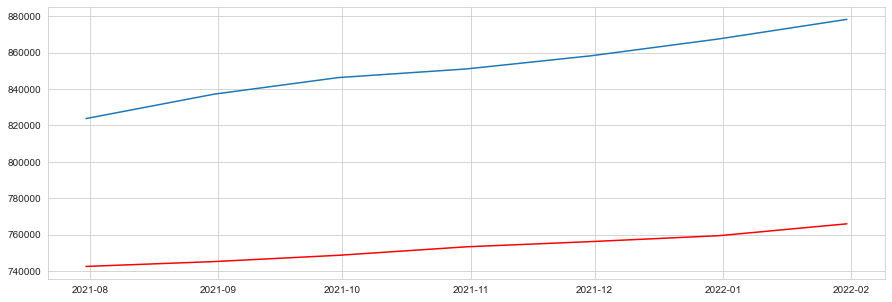

In [13]:
# Using Los Angeles, California data to train multiple linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(LA_hou_mor_train,LA_hou_mor_topred, True, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)
plt.figure(figsize=(15,5))
plt.plot(actual_pred["Date"], actual_pred['Actual'])
plt.plot(actual_pred["Date"], actual_pred['Predicted'], color="red")
plt.show()

In [14]:
# Using Denver, Colorado data to train multiple linear regression model
metrics_dict,test_pred,actual_pred = Linear_Regression(De_hou_mor_train, De_hou_mor_topred,True, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     480150.0   480489.127912
78     439103.0   446375.394354
17     288263.0   295201.211720
R2 score for test prediction: 0.97

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  548111.0  499671.918239
103 2021-08-31  558073.0  502037.298960
104 2021-09-30  565270.0  505015.793015
105 2021-10-31  571458.0  509000.320176
106 2021-11-30  579038.0  511496.426043
107 2021-12-31  588258.0  514331.610912
108 2022-01-31  598233.0  519822.028156
R2 score for actual prediction: -15.13


In [15]:
# Using Dallas, Texas data to train multiple linear regression model
metrics_dict,test_pred, actual_pred = Linear_Regression(Da_hou_mor_train, Da_hou_mor_topred,True, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     274892.0   274304.166597
78     253425.0   255371.537907
17     168696.0   171035.419851
R2 score for test prediction: 0.99

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  311657.0  285029.045068
103 2021-08-31  319551.0  286346.712664
104 2021-09-30  326735.0  288014.830130
105 2021-10-31  332809.0  290255.383462
106 2021-11-30  338271.0  291648.547923
107 2021-12-31  344143.0  293233.995837
108 2022-01-31  351550.0  296332.880722
R2 score for actual prediction: -10.09


In [16]:
# Using Virginia Beach, Virginia data to train multiple linear regression model
metrics_dict,test_pred,actual_pred = Linear_Regression(VB_hou_mor_train,VB_hou_mor_topred, True, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     262693.0   259103.210097
78     241375.0   244503.928475
17     218480.0   215507.941775
R2 score for test prediction: 0.87

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  285177.0  260877.327294
103 2021-08-31  288882.0  261487.707455
104 2021-09-30  292112.0  261528.061000
105 2021-10-31  295028.0  260845.932477
106 2021-11-30  297984.0  261271.359853
107 2021-12-31  301406.0  261506.711587
108 2022-01-31  305036.0  259622.483018
R2 score for actual prediction: -27.84


In [17]:
# Using King, Washington data to train multiple linear regression model
metrics_dict,test_pred,actual_pred = Linear_Regression(Ki_hou_mor_train,Ki_hou_mor_topred, True, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     588871.0   574481.756042
78     507881.0   528563.176633
17     331888.0   333018.284035
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  668077.0  598870.978905
103 2021-08-31  681454.0  601965.473880
104 2021-09-30  689764.0  605700.061077
105 2021-10-31  697361.0  610532.302585
106 2021-11-30  708330.0  613749.167369
107 2021-12-31  719871.0  617347.878955
108 2022-01-31  733604.0  623796.314778
R2 score for actual prediction: -17.65


<b>Scaled train data</b>

In [18]:
# Using Los Angeles, California data to train multiple linear regression model
metrics_dict, test_pred,actual_pred = Linear_Regression(LA_hou_mor_train,LA_hou_mor_topred, True, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     735908.0   720414.605823
78     662697.0   682306.600922
17     516419.0   510026.083104
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  823806.0  742457.380786
103 2021-08-31  837248.0  745138.058466
104 2021-09-30  846358.0  748583.049384
105 2021-10-31  851116.0  753261.865196
106 2021-11-30  858319.0  756111.555893
107 2021-12-31  867616.0  759372.004223
108 2022-01-31  878396.0  765909.192030
R2 score for actual prediction: -33.09


In [19]:
# Using Denver, Colorado data to train multiple linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(De_hou_mor_train,De_hou_mor_topred, True, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     480150.0   480489.127912
78     439103.0   446375.394354
17     288263.0   295201.211720
R2 score for test prediction: 0.97

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  548111.0  499671.918239
103 2021-08-31  558073.0  502037.298960
104 2021-09-30  565270.0  505015.793015
105 2021-10-31  571458.0  509000.320176
106 2021-11-30  579038.0  511496.426043
107 2021-12-31  588258.0  514331.610912
108 2022-01-31  598233.0  519822.028156
R2 score for actual prediction: -15.13


In [20]:
# Using Dallas, Texas data to train multiple linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(Da_hou_mor_train,Da_hou_mor_topred, True, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     274892.0   274304.166597
78     253425.0   255371.537907
17     168696.0   171035.419851
R2 score for test prediction: 0.99

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  311657.0  285029.045068
103 2021-08-31  319551.0  286346.712664
104 2021-09-30  326735.0  288014.830130
105 2021-10-31  332809.0  290255.383462
106 2021-11-30  338271.0  291648.547923
107 2021-12-31  344143.0  293233.995837
108 2022-01-31  351550.0  296332.880722
R2 score for actual prediction: -10.09


In [21]:
# Using Virginia Beach, Virginia data to train multiple linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(VB_hou_mor_train,VB_hou_mor_topred, True, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     262693.0   259103.210097
78     241375.0   244503.928475
17     218480.0   215507.941775
R2 score for test prediction: 0.87

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  285177.0  260877.327294
103 2021-08-31  288882.0  261487.707455
104 2021-09-30  292112.0  261528.061000
105 2021-10-31  295028.0  260845.932477
106 2021-11-30  297984.0  261271.359853
107 2021-12-31  301406.0  261506.711587
108 2022-01-31  305036.0  259622.483018
R2 score for actual prediction: -27.84


In [22]:
# Using King, Washington data to train multiple linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(Ki_hou_mor_train,Ki_hou_mor_topred, True, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     588871.0   574481.756042
78     507881.0   528563.176633
17     331888.0   333018.284035
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  668077.0  598870.978905
103 2021-08-31  681454.0  601965.473880
104 2021-09-30  689764.0  605700.061077
105 2021-10-31  697361.0  610532.302585
106 2021-11-30  708330.0  613749.167369
107 2021-12-31  719871.0  617347.878955
108 2022-01-31  733604.0  623796.314778
R2 score for actual prediction: -17.65


# Linear Regression model: only considering date

<b>Linear Regression model:</b>

<b>training data not scaled </b>

In [23]:
# Using Los Angeles, California data to train linear regression model
metrics_dict, test_pred,actual_pred = Linear_Regression(LA_hou_mor_train,LA_hou_mor_topred, False, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     735908.0   729531.461297
78     662697.0   681437.333485
17     516419.0   509354.876168
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  823806.0  749176.846839
103 2021-08-31  837248.0  752049.521140
104 2021-09-30  846358.0  754829.528528
105 2021-10-31  851116.0  757702.202829
106 2021-11-30  858319.0  760482.210217
107 2021-12-31  867616.0  763354.884518
108 2022-01-31  878396.0  766227.558819
R2 score for actual prediction: -30.08


In [24]:
# Using Denver, Colorado data to train linear regression model
metrics_dict, test_pred,actual_pred = Linear_Regression(De_hou_mor_train,De_hou_mor_topred, False, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     480150.0   487876.767358
78     439103.0   445671.002975
17     288263.0   294657.314228
R2 score for test prediction: 0.97

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  548111.0  505116.886913
103 2021-08-31  558073.0  507637.847792
104 2021-09-30  565270.0  510077.487352
105 2021-10-31  571458.0  512598.448230
106 2021-11-30  579038.0  515038.087790
107 2021-12-31  588258.0  517559.048668
108 2022-01-31  598233.0  520080.009546
R2 score for actual prediction: -13.43


In [25]:
# Using Dallas, Texas data to train linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(Da_hou_mor_train,Da_hou_mor_topred, False, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     274892.0   278514.994539
78     253425.0   254970.046886
17     168696.0   170725.407596
R2 score for test prediction: 0.98

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  311657.0  288132.583946
103 2021-08-31  319551.0  289538.929567
104 2021-09-30  326735.0  290899.909200
105 2021-10-31  332809.0  292306.254821
106 2021-11-30  338271.0  293667.234454
107 2021-12-31  344143.0  295073.580075
108 2022-01-31  351550.0  296479.925696
R2 score for actual prediction: -9.13


In [26]:
# Using Virginia Beach, Virginia data to train linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(VB_hou_mor_train,VB_hou_mor_topred, False, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     262693.0   253205.912667
78     241375.0   245066.219786
17     218480.0   215942.116360
R2 score for test prediction: 0.83

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  285177.0  256530.796849
103 2021-08-31  288882.0  257016.982743
104 2021-09-30  292112.0  257487.485222
105 2021-10-31  295028.0  257973.671117
106 2021-11-30  297984.0  258444.173595
107 2021-12-31  301406.0  258930.359490
108 2022-01-31  305036.0  259416.545384
R2 score for actual prediction: -32.66


In [27]:
# Using King, Washington data to train linear regression model
metrics_dict, test_pred,actual_pred = Linear_Regression(Ki_hou_mor_train,Ki_hou_mor_topred, False, False)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     588871.0   582410.529201
78     507881.0   527807.189622
17     331888.0   332434.546852
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  668077.0  604714.783518
103 2021-08-31  681454.0  607976.254668
104 2021-09-30  689764.0  611132.517071
105 2021-10-31  697361.0  614393.988222
106 2021-11-30  708330.0  617550.250625
107 2021-12-31  719871.0  620811.721775
108 2022-01-31  733604.0  624073.192925
R2 score for actual prediction: -16.12


<b>scaled training data:</b>

In [28]:
# Using Los Angeles, California data to train linear regression model
metrics_dict, test_pred,actual_pred = Linear_Regression(LA_hou_mor_train, LA_hou_mor_topred,False, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     735908.0   729531.461297
78     662697.0   681437.333485
17     516419.0   509354.876168
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  823806.0  749176.846839
103 2021-08-31  837248.0  752049.521140
104 2021-09-30  846358.0  754829.528528
105 2021-10-31  851116.0  757702.202829
106 2021-11-30  858319.0  760482.210217
107 2021-12-31  867616.0  763354.884518
108 2022-01-31  878396.0  766227.558819
R2 score for actual prediction: -30.08


In [29]:
# Using Denver, Colorado data to train linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(De_hou_mor_train,De_hou_mor_topred, False, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     480150.0   487876.767358
78     439103.0   445671.002975
17     288263.0   294657.314228
R2 score for test prediction: 0.97

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  548111.0  505116.886913
103 2021-08-31  558073.0  507637.847792
104 2021-09-30  565270.0  510077.487352
105 2021-10-31  571458.0  512598.448230
106 2021-11-30  579038.0  515038.087790
107 2021-12-31  588258.0  517559.048668
108 2022-01-31  598233.0  520080.009546
R2 score for actual prediction: -13.43


In [30]:
# Using Dallas, Texas data to train linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(Da_hou_mor_train,Da_hou_mor_topred, False, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     274892.0   278514.994539
78     253425.0   254970.046886
17     168696.0   170725.407596
R2 score for test prediction: 0.98

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  311657.0  288132.583946
103 2021-08-31  319551.0  289538.929567
104 2021-09-30  326735.0  290899.909200
105 2021-10-31  332809.0  292306.254821
106 2021-11-30  338271.0  293667.234454
107 2021-12-31  344143.0  295073.580075
108 2022-01-31  351550.0  296479.925696
R2 score for actual prediction: -9.13


In [31]:
# Using Virginia Beach, Virginia data to train linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(VB_hou_mor_train,VB_hou_mor_topred, False, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     262693.0   253205.912667
78     241375.0   245066.219786
17     218480.0   215942.116360
R2 score for test prediction: 0.83

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  285177.0  256530.796849
103 2021-08-31  288882.0  257016.982743
104 2021-09-30  292112.0  257487.485222
105 2021-10-31  295028.0  257973.671117
106 2021-11-30  297984.0  258444.173595
107 2021-12-31  301406.0  258930.359490
108 2022-01-31  305036.0  259416.545384
R2 score for actual prediction: -32.66


In [32]:
# Using King, Washington data to train linear regression model
metrics_dict, test_pred, actual_pred = Linear_Regression(Ki_hou_mor_train,Ki_hou_mor_topred, False, True)
metrics_df = metrics_df.append(metrics_dict, ignore_index =True)

Test Prediction
    Actual_test  Predicted_test
95     588871.0   582410.529201
78     507881.0   527807.189622
17     331888.0   332434.546852
R2 score for test prediction: 0.96

Actual prediction
          Date    Actual      Predicted
102 2021-07-31  668077.0  604714.783518
103 2021-08-31  681454.0  607976.254668
104 2021-09-30  689764.0  611132.517071
105 2021-10-31  697361.0  614393.988222
106 2021-11-30  708330.0  617550.250625
107 2021-12-31  719871.0  620811.721775
108 2022-01-31  733604.0  624073.192925
R2 score for actual prediction: -16.12


In [33]:
metrics_df

,county_state,mul_linear_reg,scale,R2,R2_pred,MAE,MSE,RMSE
0,"Los Angeles, California",1,0,0.96,-33.09,10027.79,2.417569e+08,15548.53
1,"Denver, Colorado",1,0,0.97,-15.13,8251.81,1.125054e+08,10606.86
2,"Dallas, Texas",1,0,0.99,-10.09,2896.51,2.016231e+07,4490.25
3,"Virginia Beach, Virginia",1,0,0.87,-27.84,4179.71,3.269075e+07,5717.58
4,"King, Washington",1,0,0.96,-17.65,12755.23,2.759199e+08,16610.84
5,"Los Angeles, California",1,1,0.96,-33.09,10027.79,2.417569e+08,15548.53
6,"Denver, Colorado",1,1,0.97,-15.13,8251.81,1.125054e+08,10606.86
7,"Dallas, Texas",1,1,0.99,-10.09,2896.51,2.016231e+07,4490.25
8,"Virginia Beach, Virginia",1,1,0.87,-27.84,4179.71,3.269075e+07,5717.58
9,"King, Washington",1,1,0.96,-17.65,12755.23,2.759199e+08,16610.84


In [34]:
metrics_df.to_csv("../data/processed data/metrics_LR.csv", index = False)

In general, both linear regression models with and without scaling have good R2 score and other model metrics while testing. 
The predicted values show negative R2 score. We can see if a time series model would work better.

# Time Series Ananlysis and modelling

Since there is no correlation between covid case numbers and the housing prices, we can try training an univariate time series model and see if the predictions come as near to the actual housing price values between July 2021 and January 2022.

<b>For Dalla, Texas:</b>

In [35]:
Da_hou_mor_train.columns

Index(['state_name', 'county_name', 'Date', 'Price', 'mortgage_int_rate',
       'Date_ord'],
      dtype='object')

In [36]:
Da_hou_mor_ts = Da_hou_mor_train[["Date","Price","mortgage_int_rate"]]
LA_hou_mor_ts = LA_hou_mor_train[["Date","Price","mortgage_int_rate"]]
De_hou_mor_ts = De_hou_mor_train[["Date","Price","mortgage_int_rate"]]
VB_hou_mor_ts = VB_hou_mor_train[["Date","Price","mortgage_int_rate"]]
Ki_hou_mor_ts = Ki_hou_mor_train[["Date","Price","mortgage_int_rate"]]

In [37]:
Da_hou_mor_ts.set_index(Da_hou_mor_ts['Date'], inplace=True)
Da_hou_mor_ts.drop('Date',axis=1, inplace = True)

LA_hou_mor_ts.set_index(LA_hou_mor_ts['Date'], inplace=True)
LA_hou_mor_ts.drop('Date',axis=1, inplace = True)

De_hou_mor_ts.set_index(De_hou_mor_ts['Date'], inplace=True)
De_hou_mor_ts.drop('Date',axis=1, inplace = True)

VB_hou_mor_ts.set_index(VB_hou_mor_ts['Date'], inplace=True)
VB_hou_mor_ts.drop('Date',axis=1, inplace = True)

Ki_hou_mor_ts.set_index(Ki_hou_mor_ts['Date'], inplace=True)
Ki_hou_mor_ts.drop('Date',axis=1, inplace = True)

De_hou_mor_ts.head()

,Price,mortgage_int_rate
Date,,
2013-01-31,252752.0,3.4140
2013-02-28,255376.0,3.5325
2013-03-31,258087.0,3.5650
2013-04-30,260296.0,3.4450
2013-05-31,262126.0,3.5360


<AxesSubplot:xlabel='Date'>

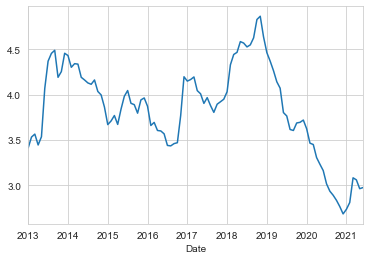

In [38]:
Da_hou_mor_ts.mortgage_int_rate.plot()

<AxesSubplot:xlabel='Date'>

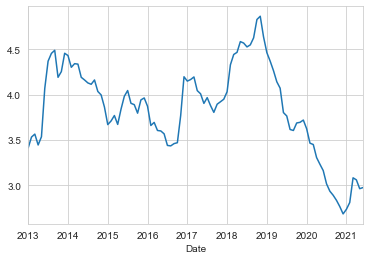

In [39]:
De_hou_mor_ts.mortgage_int_rate.plot()

<AxesSubplot:xlabel='Date'>

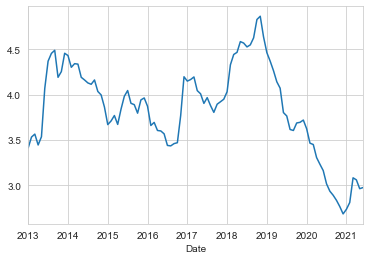

In [40]:
LA_hou_mor_ts.mortgage_int_rate.plot()

<AxesSubplot:xlabel='Date'>

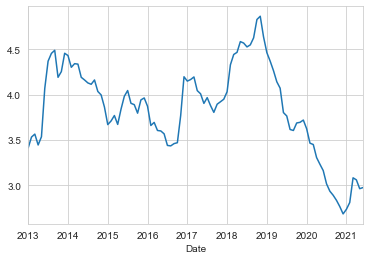

In [41]:
VB_hou_mor_ts.mortgage_int_rate.plot()

<AxesSubplot:xlabel='Date'>

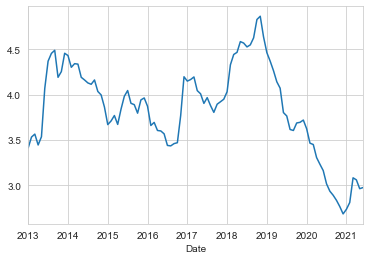

In [42]:
Ki_hou_mor_ts.mortgage_int_rate.plot()

<AxesSubplot:xlabel='Date'>

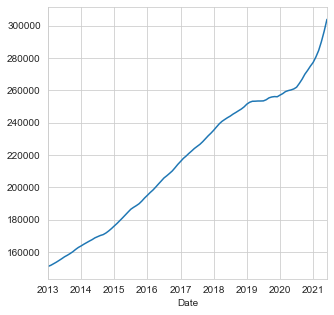

In [43]:
plt.figure(figsize=(5,5))
Da_hou_mor_ts.Price.plot()

The housing price shows trend, but no seasonality is intuitively visible. We can decompose and see for different components.

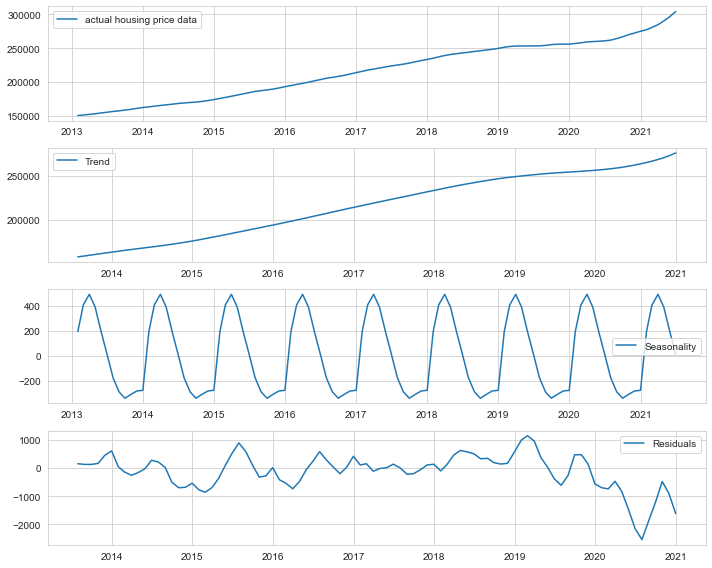

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(Da_hou_mor_ts.Price, model='additive')
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
plt.figure(figsize=(10,8))
# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(4,1,1)
plt.plot(Da_hou_mor_ts.Price, label = 'actual housing price data')
plt.legend(loc = 'best')
plt.subplot(4,1,2)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(4,1,3)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(4,1,4)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

Looks like there is a small seasonality and good trend in the data.

<b>Dickey Fuller and kpss test for stationarity of the time series</b>

In [45]:
# Dallas
from statsmodels.tsa.stattools import kpss
statistic, p_value, n_lags, critical_values = kpss(Da_hou_mor_ts.Price)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.8470488187991455
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary


In [46]:
# Denver
statistic, p_value, n_lags, critical_values = kpss(De_hou_mor_ts.Price)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.8457906842036101
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary


In [47]:
# Los Angeles
statistic, p_value, n_lags, critical_values = kpss(LA_hou_mor_ts.Price)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.8625691175409591
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary


In [48]:
# Virginia Beach
statistic, p_value, n_lags, critical_values = kpss(VB_hou_mor_ts.Price)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.7998134803459246
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary


In [49]:
# King
statistic, p_value, n_lags, critical_values = kpss(Ki_hou_mor_ts.Price)
print(f'KPSS Statistic: {statistic}')
print(f'p-value: {p_value}')
print(f'num lags: {n_lags}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS Statistic: 0.8478315323528751
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary


In [50]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Da_hou_mor_ts.Price, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
else:
    print ("Time Series is Non-Stationary")

ADF Statistic: 1.632804
p-value: 0.997953
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
Time Series is Non-Stationary


We can make the data stationary by differencing our data. 

Only differencing this time series data and trying for a best ARIMA parameters gave a large MSE values. So taking log transform and then differencing may give a smaller mse values.

In [51]:
Price_log_Da = np.log(Da_hou_mor_ts.Price)
Price_log_De = np.log(De_hou_mor_ts.Price)
Price_log_LA = np.log(LA_hou_mor_ts.Price)
Price_log_VB = np.log(VB_hou_mor_ts.Price)
Price_log_Ki = np.log(Ki_hou_mor_ts.Price)

In [52]:
# Log transform to make the series stationary
def kpss_log(Price_log):
    statistic, p_value, n_lags, critical_values = kpss(Price_log.dropna())
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'The series is {"not " if p_value < 0.05 else ""}stationary\n')

In [53]:
kpss_log(Price_log_Da)
kpss_log(Price_log_De)
kpss_log(Price_log_LA)
kpss_log(Price_log_VB)
kpss_log(Price_log_Ki)

KPSS Statistic: 0.8393810647581236
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary

KPSS Statistic: 0.8336479578182676
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary

KPSS Statistic: 0.860563605623342
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary

KPSS Statistic: 0.8097137086366372
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary

KPSS Statistic: 0.8447543517215564
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary



In [54]:
# Adding first difference to see if the series becomes stationary
def kpss_log_diff(Price_log):
    statistic, p_value, n_lags, critical_values = kpss(Price_log.diff(periods=1).dropna())
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'The series is {"not " if p_value < 0.05 else ""}stationary\n')

In [55]:
kpss_log_diff(Price_log_Da)
kpss_log_diff(Price_log_De)
kpss_log_diff(Price_log_LA)
kpss_log_diff(Price_log_VB)
kpss_log_diff(Price_log_Ki)

KPSS Statistic: 0.09385562783084714
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is stationary

KPSS Statistic: 0.1345504164516419
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is stationary

KPSS Statistic: 0.16652501704524195
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is stationary

KPSS Statistic: 0.5601675712811528
p-value: 0.02811541187361423
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is not stationary

KPSS Statistic: 0.08595642007599656
p-value: 0.1
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
The series is stationary



Now the data is stationary and we can use to train the model. Virginia Beach data doesnot get stationary even after differencing  twice. 

In [56]:
Price_log_Ki.head()

Date
2013-01-31    12.550920
2013-02-28    12.562736
2013-03-31    12.576977
2013-04-30    12.594005
2013-05-31    12.608400
Name: Price, dtype: float64

In [57]:
# Import required packages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

 <b>Plotting ACF and PACF plot to choose model order</b>

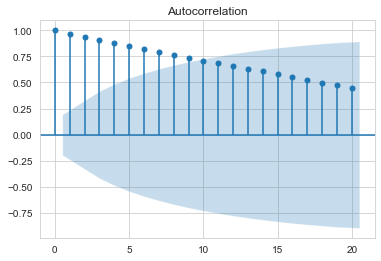

In [58]:
plot_acf(Price_log_Da, lags = 20)
plt.show()

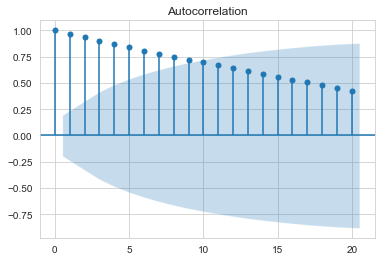

In [59]:
plot_acf(Price_log_De, lags = 20)
plt.show()

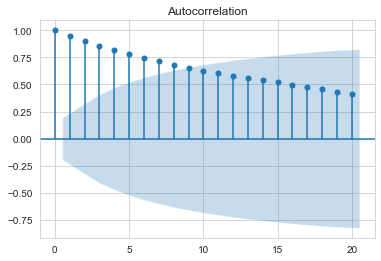

In [60]:
plot_acf(Price_log_LA, lags = 20)
plt.show()

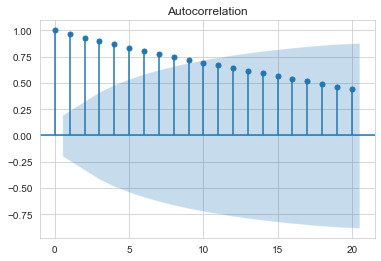

In [61]:
plot_acf(Price_log_Ki, lags = 20)
plt.show()

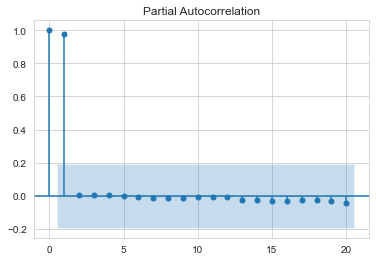

In [62]:
plot_pacf(Price_log_Da, lags=20)
plt.show()

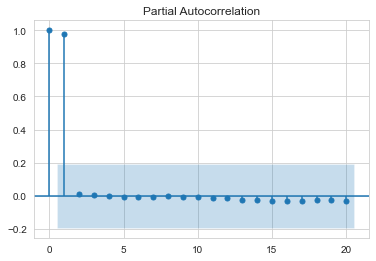

In [63]:
plot_pacf(Price_log_De, lags=20)
plt.show()

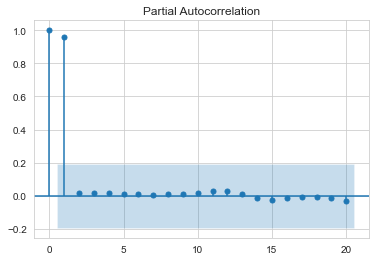

In [64]:
plot_pacf(Price_log_LA, lags=20)
plt.show()

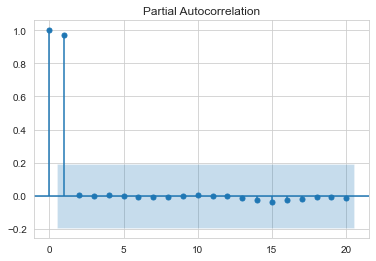

In [65]:
plot_pacf(Price_log_Ki, lags=20)
plt.show()

The above plots have ACF that is tailing off and PACF cutting off at lag p = 1. So this is a AR(1) model. 

<b> Dallas, Texas: Time series model training and prediction </b>

In [110]:
model = ARIMA(Price_log_Da, order=(1,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(7)

In [111]:
forecast[0]

array([12.64869109, 12.67307299, 12.6974549 , 12.7218368 , 12.74621871,
       12.77060061, 12.79498252])

In [112]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 497.763
Method:                       css-mle   S.D. of innovations              0.002
Date:                Tue, 17 May 2022   AIC                           -989.526
Time:                        14:30:01   BIC                           -981.680
Sample:                    02-28-2013   HQIC                          -986.350
                         - 06-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0226        nan        nan        nan         nan         nan
ar.L1.D.Price     1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

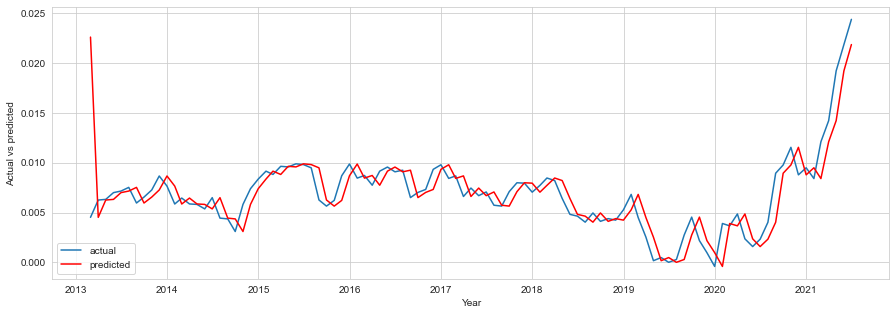

In [113]:
# plot the actual vs predicted (transformed and differenced) data
plt.figure(figsize=(15,5))
plt.plot(Price_log_Da.diff(periods=1), label="actual")
plt.plot(model_fit.predict(), color = 'red', label="predicted")
plt.xlabel("Year")
plt.ylabel("Actual vs predicted")
plt.legend()

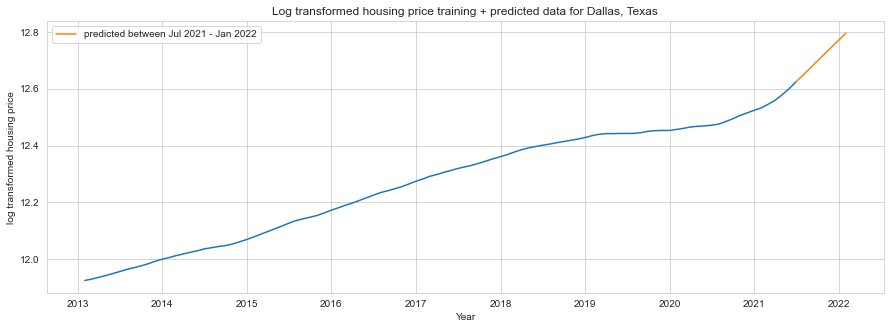

In [114]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 8
date_range = pd.date_range("2021-07-31", periods = forecast_period, 
              freq='M').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Date'] = pd.to_datetime(future_months['Date'])

df = pd.DataFrame(forecast[0])
future_months['Prediction'] = df.iloc[:,0]
future_months.set_index('Date', inplace = True)

# Plot your future predictions
plt.figure(figsize=(15,5))
plt.plot(Price_log_Da)
plt.plot(Price_log_Da['Jun 2021'].append(future_months['Prediction']), label="predicted between Jul 2021 - Jan 2022")
plt.title("Log transformed housing price training + predicted data for Dallas, Texas")
plt.xlabel("Year")
plt.ylabel("log transformed housing price")
plt.legend()
plt.show()

In [115]:
Da_hou_mor_ts_p = Da_hou_mor_topred[["Date","Price","mortgage_int_rate"]]
Da_hou_mor_ts_p.set_index(Da_hou_mor_ts_p['Date'], inplace=True)
Da_hou_mor_ts_p.drop('Date',axis=1, inplace = True)

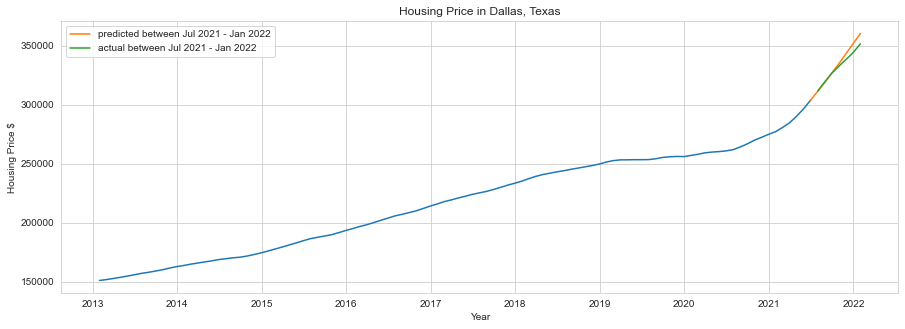

In [116]:
# Now plot the original Da_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(Da_hou_mor_ts.Price)
plt.plot(np.exp(Price_log_Da['Jun 2021'].append(future_months['Prediction'])), label="predicted between Jul 2021 - Jan 2022")
plt.plot(Da_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in Dallas, Texas")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

Plot the whole future actual data with the above graph to see the difference.

In [117]:
np.exp(future_months['Prediction'])

Date
2021-07-31    311355.644442
2021-08-31    319040.391915
2021-09-30    326914.811054
2021-10-31    334983.583253
2021-11-30    343251.505453
2021-12-31    351723.492988
2022-01-31    360404.582513
2022-02-28              NaN
Name: Prediction, dtype: float64

In [118]:
Da_hou_mor_ts_p.Price

Date
2021-07-31    311657.0
2021-08-31    319551.0
2021-09-30    326735.0
2021-10-31    332809.0
2021-11-30    338271.0
2021-12-31    344143.0
2022-01-31    351550.0
Name: Price, dtype: float64

In [119]:
actual = Da_hou_mor_ts_p["Price"].iloc[:5]
predicted = np.exp(future_months['Prediction']).iloc[:5]
R2_pred = round(r2_score(actual,predicted),2)
R2_pred

0.93

In [121]:
MAE = round(mean_absolute_error(actual, predicted),2)
MSE = round(mean_squared_error(actual, predicted),2)
RMSE = np.sqrt(MSE)
print(MAE,MSE, RMSE)

1629.37 5983622.94 2446.14450513456


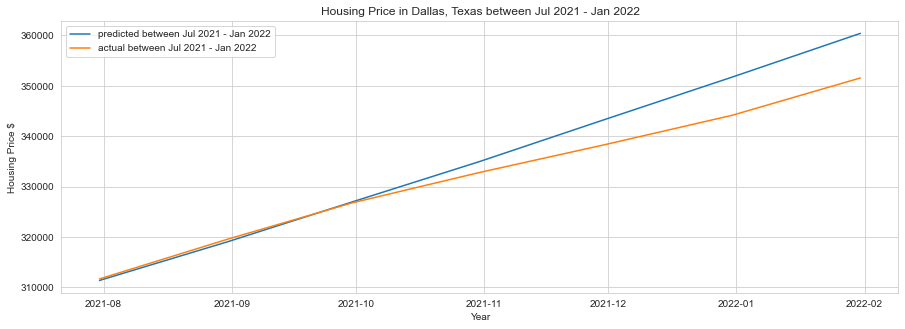

In [76]:
# Now plot the original Da_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(np.exp(future_months['Prediction']),label="predicted between Jul 2021 - Jan 2022")
plt.plot(Da_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in Dallas, Texas between Jul 2021 - Jan 2022")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

For Dallas, Texas , the time series prediction matches almost with the actual housing price values. Univariate time series model can be used to predict the housing price.

<b> Denver, Colorado: Time series model training and prediction </b>

In [77]:
model = ARIMA(Price_log_De, order=(1,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(7)

In [78]:
forecast[0]

array([13.21379379, 13.23849897, 13.26297497, 13.28722614, 13.31125676,
       13.33507101, 13.35867301])

In [79]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 513.821
Method:                       css-mle   S.D. of innovations              0.001
Date:                Tue, 17 May 2022   AIC                          -1021.642
Time:                        14:22:38   BIC                          -1013.797
Sample:                    02-28-2013   HQIC                         -1018.466
                         - 06-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0126      0.006      2.099      0.036       0.001       0.024
ar.L1.D.Price     0.9810      0.019     51.544      0.000       0.944       1.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0194           +0.0000j            1.0194            0.0000
-----------------------------------------------------------------------------
"""

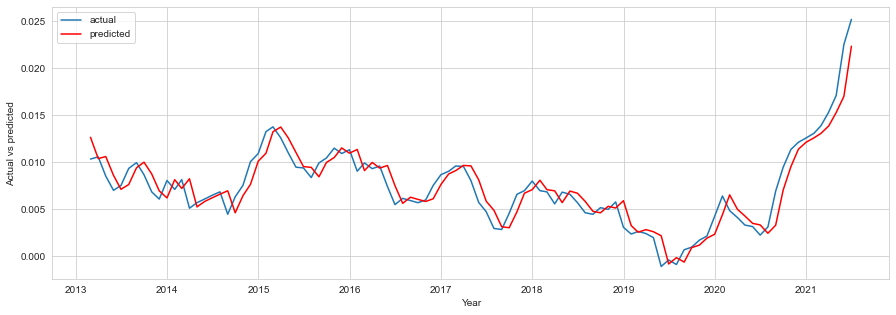

In [80]:
# plot the actual vs predicted (transformed and differenced) data
plt.figure(figsize=(15,5))
plt.plot(Price_log_De.diff(periods=1), label="actual")
plt.plot(model_fit.predict(), color = 'red', label="predicted")
plt.xlabel("Year")
plt.ylabel("Actual vs predicted")
plt.legend()

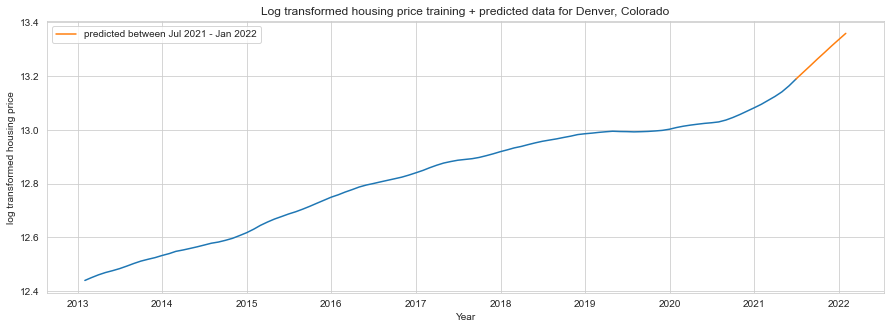

In [81]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 8
date_range = pd.date_range("2021-07-31", periods = forecast_period, 
              freq='M').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Date'] = pd.to_datetime(future_months['Date'])

df = pd.DataFrame(forecast[0])
future_months['Prediction'] = df.iloc[:,0]
future_months.set_index('Date', inplace = True)

# Plot your future predictions
plt.figure(figsize=(15,5))
plt.plot(Price_log_De)
plt.plot(Price_log_De['Jun 2021'].append(future_months['Prediction']), label="predicted between Jul 2021 - Jan 2022")
plt.title("Log transformed housing price training + predicted data for Denver, Colorado")
plt.xlabel("Year")
plt.ylabel("log transformed housing price")
plt.legend()
plt.show()

In [82]:
De_hou_mor_ts_p = De_hou_mor_topred[["Date","Price","mortgage_int_rate"]]
De_hou_mor_ts_p.set_index(De_hou_mor_ts_p['Date'], inplace=True)
De_hou_mor_ts_p.drop('Date',axis=1, inplace = True)

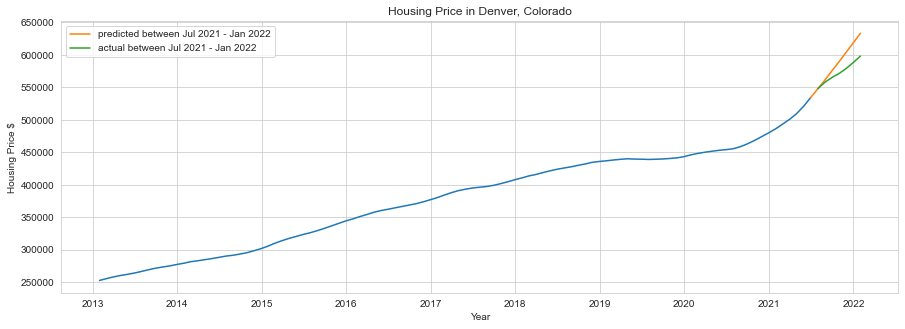

In [83]:
# Now plot the original De_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(De_hou_mor_ts.Price)
plt.plot(np.exp(Price_log_De['Jun 2021'].append(future_months['Prediction'])), label="predicted between Jul 2021 - Jan 2022")
plt.plot(De_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in Denver, Colorado")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

In [84]:
np.exp(future_months['Prediction'])

Date
2021-07-31    547870.261091
2021-08-31    561574.075299
2021-09-30    575488.755819
2021-10-31    589615.638169
2021-11-30    603956.081329
2021-12-31    618511.468858
2022-01-31    633283.209979
2022-02-28              NaN
Name: Prediction, dtype: float64

In [85]:
De_hou_mor_ts_p.Price

Date
2021-07-31    548111.0
2021-08-31    558073.0
2021-09-30    565270.0
2021-10-31    571458.0
2021-11-30    579038.0
2021-12-31    588258.0
2022-01-31    598233.0
Name: Price, dtype: float64

In [86]:
actual = De_hou_mor_ts_p["Price"].iloc[:5]
predicted = np.exp(future_months['Prediction']).iloc[:5]
R2_pred = round(r2_score(actual,predicted),2)
R2_pred

-0.87

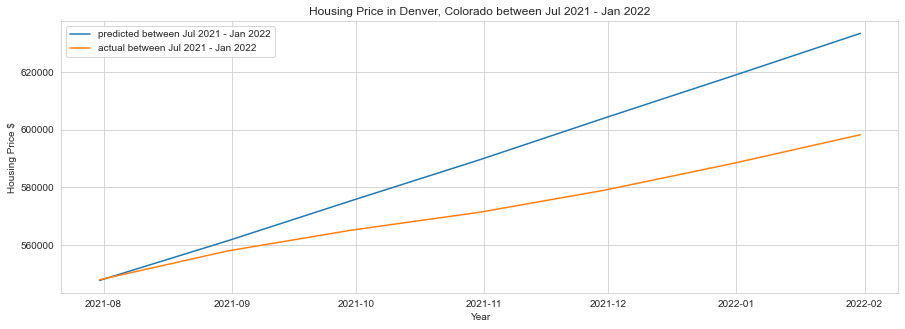

In [87]:
# Now plot the original De_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(np.exp(future_months['Prediction']),label="predicted between Jul 2021 - Jan 2022")
plt.plot(De_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in Denver, Colorado between Jul 2021 - Jan 2022")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

<b>Los Angeles, California : Time series model training and prediction:</b>

In [88]:
model = ARIMA(Price_log_LA, order=(1,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(7)

In [89]:
forecast[0]

array([13.61984221, 13.64264193, 13.6644729 , 13.68540652, 13.70550891,
       13.72484135, 13.74346059])

In [90]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 444.255
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 17 May 2022   AIC                           -882.509
Time:                        14:22:40   BIC                           -874.664
Sample:                    02-28-2013   HQIC                          -879.333
                         - 06-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0097      0.004      2.410      0.016       0.002       0.018
ar.L1.D.Price     0.9263      0.047     19.911      0.000       0.835       1.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0796           +0.0000j            1.0796            0.0000
-----------------------------------------------------------------------------
"""

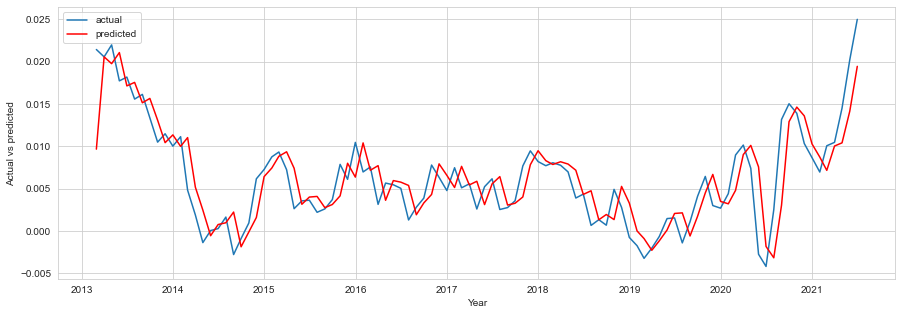

In [91]:
# plot the actual vs predicted (transformed and differenced) data
plt.figure(figsize=(15,5))
plt.plot(Price_log_LA.diff(periods=1), label="actual")
plt.plot(model_fit.predict(), color = 'red', label="predicted")
plt.xlabel("Year")
plt.ylabel("Actual vs predicted")
plt.legend()

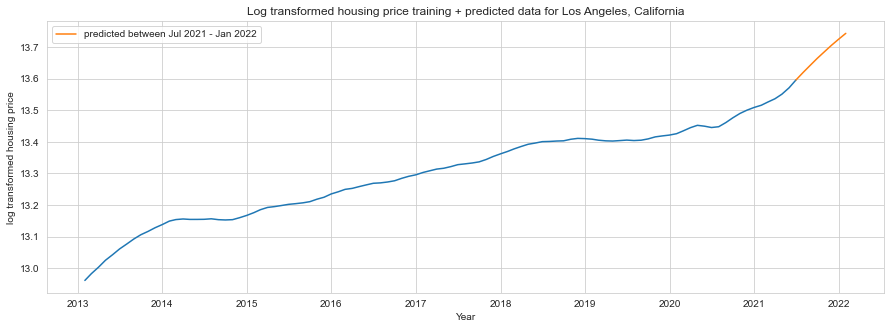

In [92]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 8
date_range = pd.date_range("2021-07-31", periods = forecast_period, 
              freq='M').strftime("%Y-%m-%d").tolist()
# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Date'] = pd.to_datetime(future_months['Date'])

df = pd.DataFrame(forecast[0])
future_months['Prediction'] = df.iloc[:,0]
future_months.set_index('Date', inplace = True)

# Plot your future predictions
plt.figure(figsize=(15,5))
plt.plot(Price_log_LA)
plt.plot(Price_log_LA['Jun 2021'].append(future_months['Prediction']), label="predicted between Jul 2021 - Jan 2022")
plt.title("Log transformed housing price training + predicted data for Los Angeles, California")
plt.xlabel("Year")
plt.ylabel("log transformed housing price")
plt.legend()
plt.show()

In [93]:
LA_hou_mor_ts_p = LA_hou_mor_topred[["Date","Price","mortgage_int_rate"]]
LA_hou_mor_ts_p.set_index(LA_hou_mor_ts_p['Date'], inplace=True)
LA_hou_mor_ts_p.drop('Date',axis=1, inplace = True)

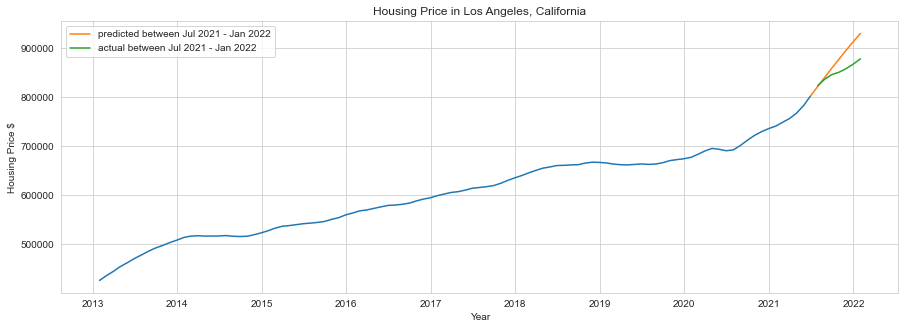

In [94]:
# Now plot the original LA_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(LA_hou_mor_ts.Price)
plt.plot(np.exp(Price_log_LA['Jun 2021'].append(future_months['Prediction'])), label="predicted between Jul 2021 - Jan 2022")
plt.plot(LA_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in Los Angeles, California")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

In [95]:
np.exp(future_months['Prediction'])

Date
2021-07-31    822284.904709
2021-08-31    841248.127084
2021-09-30    859815.320409
2021-10-31    878004.076469
2021-11-30    895832.660858
2021-12-31    913319.782726
2022-01-31    930484.396165
2022-02-28              NaN
Name: Prediction, dtype: float64

In [96]:
LA_hou_mor_ts_p.Price

Date
2021-07-31    823806.0
2021-08-31    837248.0
2021-09-30    846358.0
2021-10-31    851116.0
2021-11-30    858319.0
2021-12-31    867616.0
2022-01-31    878396.0
Name: Price, dtype: float64

In [97]:
actual = LA_hou_mor_ts_p["Price"].iloc[:5]
predicted = np.exp(future_months['Prediction']).iloc[:5]
R2_pred = round(r2_score(actual,predicted),2)
R2_pred

-2.27

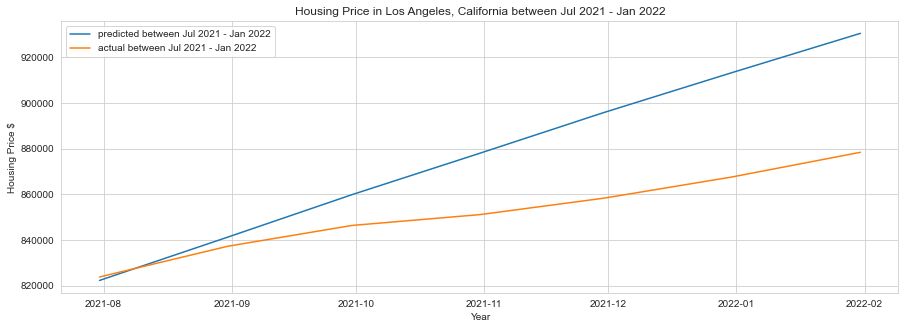

In [98]:
# Now plot the original LA_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(np.exp(future_months['Prediction']),label="predicted between Jul 2021 - Jan 2022")
plt.plot(LA_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in Los Angeles, California between Jul 2021 - Jan 2022")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

<b> King, Washington: Time series model training and predictions: </b>

In [99]:
model = ARIMA(Price_log_Ki, order=(1,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(7)

In [100]:
forecast[0]

array([13.41421064, 13.438605  , 13.46170309, 13.48362294, 13.50447185,
       13.52434732, 13.54333801])

In [101]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 450.118
Method:                       css-mle   S.D. of innovations              0.003
Date:                Tue, 17 May 2022   AIC                           -894.236
Time:                        14:22:41   BIC                           -886.391
Sample:                    02-28-2013   HQIC                          -891.060
                         - 06-30-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0102      0.003      3.474      0.001       0.004       0.016
ar.L1.D.Price     0.9089      0.048     18.786      0.000       0.814       1.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1002           +0.0000j            1.1002            0.0000
-----------------------------------------------------------------------------
"""

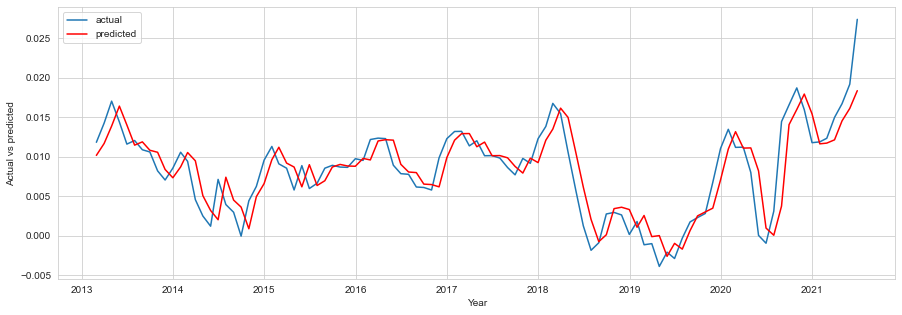

In [102]:
# plot the actual vs predicted (transformed and differenced) data
plt.figure(figsize=(15,5))
plt.plot(Price_log_Ki.diff(periods=1), label="actual")
plt.plot(model_fit.predict(), color = 'red', label="predicted")
plt.xlabel("Year")
plt.ylabel("Actual vs predicted")
plt.legend()

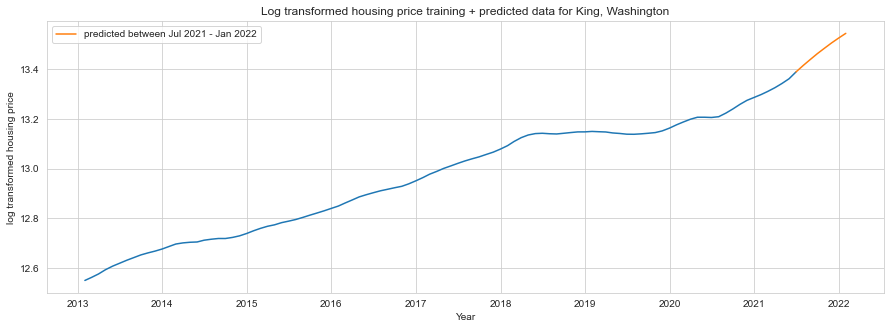

In [103]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period= 8
date_range = pd.date_range("2021-07-31", periods = forecast_period, 
              freq='M').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_months = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Month' column to a datetime object with to_datetime 
future_months['Date'] = pd.to_datetime(future_months['Date'])

df = pd.DataFrame(forecast[0])
future_months['Prediction'] = df.iloc[:,0]
future_months.set_index('Date', inplace = True)

# Plot your future predictions
plt.figure(figsize=(15,5))
plt.plot(Price_log_Ki)
plt.plot(Price_log_Ki['Jun 2021'].append(future_months['Prediction']), label="predicted between Jul 2021 - Jan 2022")
plt.title("Log transformed housing price training + predicted data for King, Washington")
plt.xlabel("Year")
plt.ylabel("log transformed housing price")
plt.legend()
plt.show()

In [104]:
Ki_hou_mor_ts_p = Ki_hou_mor_topred[["Date","Price","mortgage_int_rate"]]
Ki_hou_mor_ts_p.set_index(Ki_hou_mor_ts_p['Date'], inplace=True)
Ki_hou_mor_ts_p.drop('Date',axis=1, inplace = True)

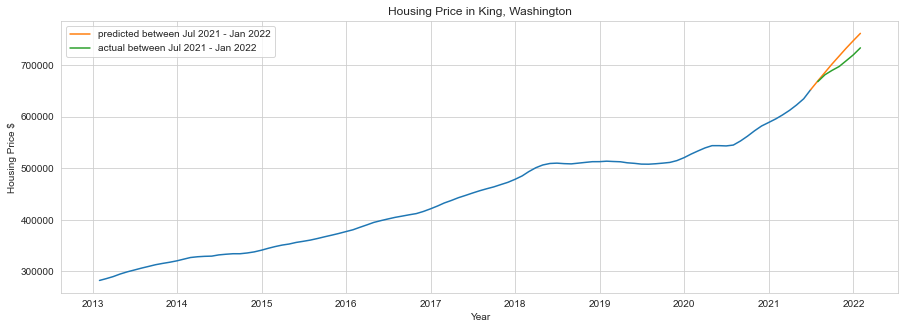

In [105]:
# Now plot the original Ki_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(Ki_hou_mor_ts.Price)
plt.plot(np.exp(Price_log_Ki['Jun 2021'].append(future_months['Prediction'])), label="predicted between Jul 2021 - Jan 2022")
plt.plot(Ki_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in King, Washington")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()

In [106]:
np.exp(future_months['Prediction'])

Date
2021-07-31    669449.252261
2021-08-31    685980.855596
2021-09-30    702010.112235
2021-10-31    717567.961659
2021-11-30    732685.513507
2021-12-31    747393.668040
2022-01-31    761722.813054
2022-02-28              NaN
Name: Prediction, dtype: float64

In [107]:
Ki_hou_mor_ts_p.Price

Date
2021-07-31    668077.0
2021-08-31    681454.0
2021-09-30    689764.0
2021-10-31    697361.0
2021-11-30    708330.0
2021-12-31    719871.0
2022-01-31    733604.0
Name: Price, dtype: float64

In [108]:
actual = Ki_hou_mor_ts_p["Price"].iloc[:5]
predicted = np.exp(future_months['Prediction']).iloc[:5]
R2_pred = round(r2_score(actual,predicted),2)
R2_pred

-0.25

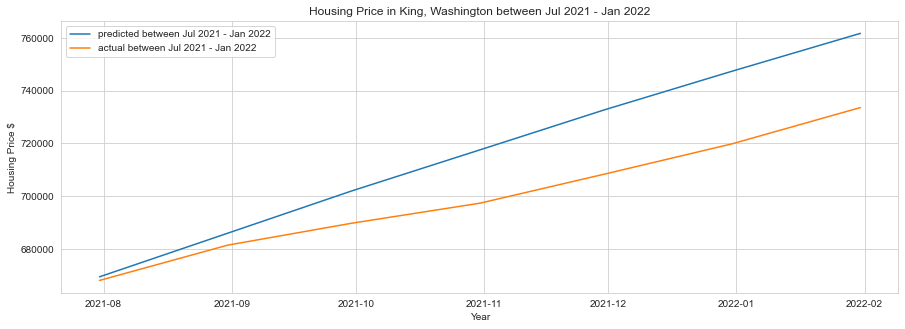

In [109]:
# Now plot the original Ki_hou_mor_ts
# Use the same functions as before
plt.figure(figsize=(15,5))
plt.plot(np.exp(future_months['Prediction']),label="predicted between Jul 2021 - Jan 2022")
plt.plot(Ki_hou_mor_ts_p.Price, label="actual between Jul 2021 - Jan 2022")
plt.title("Housing Price in King, Washington between Jul 2021 - Jan 2022")
plt.xlabel("Year")
plt.ylabel("Housing Price $")
plt.legend()
plt.show()